# Data exploration

In [213]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
import spacy
import sklearn
import sklearn.metrics as metrics
import nltk
import string
import nltk.data
from statannot import add_stat_annotation
from matplotlib import gridspec

from scipy.sparse.linalg import lobpcg
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from scipy.stats import ttest_ind
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [214]:
from matplotlib import rc

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})

# Set the font used for MathJax - more on this later
rc('mathtext',**{'default':'regular'})

In [215]:
%matplotlib inline

# The following %config line changes the inline figures to have a higher DPI.
# You can comment out (#) this line if you don't have a high-DPI (~220) display.
%config InlineBackend.figure_format = 'retina'

<a id='home'></a>
## Table of contents
[Import des données](#0)<br>

[Exploration de données](#1)<br>
    1.1. [Analyse des labels à prédire](#11)<br>
    1.2. [Analyse du commentaire](#12)<br>


<a id='0'></a>
## Import des données
<a href='#home'>Back home</a>

In [216]:
train = pd.read_csv('../data/train.csv', index_col=0)
train.head(10)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0


In [217]:
labels = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

<a id='1'></a>
### Exploration de données
<a href='#home'>Back home</a>

**Recherche de valeurs null**

In [218]:
print('Nombre de valeurs manquantes parmi les {} échantillons de train : '.format(train.shape[0]))
print("comment_text : {}".format(train.comment_text.isna().sum()))
print("toxic : {}".format(train.toxic.isna().sum()))
print("severe_toxic : {}".format(train.severe_toxic.isna().sum()))
print("obscene : {}".format(train.obscene.isna().sum()))
print("threat : {}".format(train.threat.isna().sum()))
print("insult : {}".format(train.insult.isna().sum()))
print("identity_hate : {}".format(train.identity_hate.isna().sum()))

Nombre de valeurs manquantes parmi les 159571 échantillons de train : 
comment_text : 0
toxic : 0
severe_toxic : 0
obscene : 0
threat : 0
insult : 0
identity_hate : 0


**Pistes d'exploration**

- longueur des commentaires
- utilisation des majuscules dans les commentaires : calculer un ratio entre nombre de majuscules et longueur du texte
- utilisation de la ponctuation dans les commentaires : calculer un ratio entre nombre de signes de ponctuation et longueur du texte
- correlation entre 2 niveaux de toxicité
- nombre de niveaux de toxicité par commentaire

In [219]:
train['total'] = train.toxic + train.severe_toxic + train.obscene + train.threat + train.insult + train.identity_hate

In [220]:
train['comment_text_len'] = train['comment_text'].apply(lambda x: len(x.split()))

In [221]:
train['comment_caract_len'] = train['comment_text'].str.len()

In [222]:
def is_upper(name):
    count=0
    for i in name:
        if i.isupper():
            count=count+1
    return count

In [223]:
train['uppercases'] = train['comment_text'].apply(lambda x: is_upper(x)) / train.comment_caract_len

In [224]:
punct = lambda l1,l2: sum([1 for x in l1 if x in l2])

In [225]:
train['punctation'] = train['comment_text'].apply(lambda x: punct(x,set(string.punctuation)) ) / train.comment_caract_len

In [226]:
train['type'] = train.total.apply(lambda x: 'neutre' if x==0 else 'toxique')

In [227]:
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,total,comment_text_len,comment_caract_len,uppercases,punctation,type
id,,,,,,,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,43,264,0.064394,0.037879,neutre
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,17,112,0.071429,0.107143,neutre
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,42,233,0.017167,0.025751,neutre
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,113,622,0.017685,0.033762,neutre
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,13,67,0.029851,0.074627,neutre


<a id='11'></a>
#### 1.1.  Analyse exploratoire des labels

##### Répartition des labels

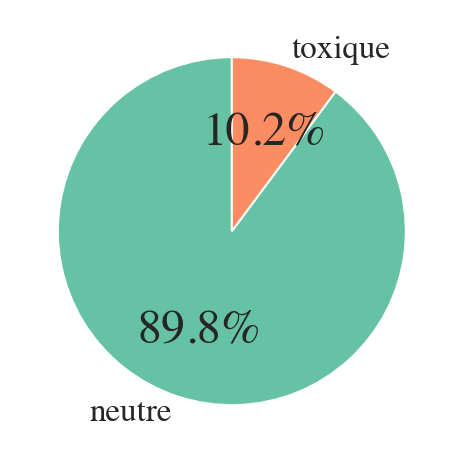

In [228]:
sns.set_palette("Set2")
matplotlib.rcParams['font.family'] = "times"
matplotlib.rcParams['font.size'] = 24

fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
ax0.pie(train.type.value_counts(), labels=train.type.unique(),
        shadow=False, autopct='%1.1f%%', startangle=90)
plt.savefig('../plots/label_distribution.png', bbox_inches='tight');
#ax0.set_title('% total', fontweight="bold", size=12)

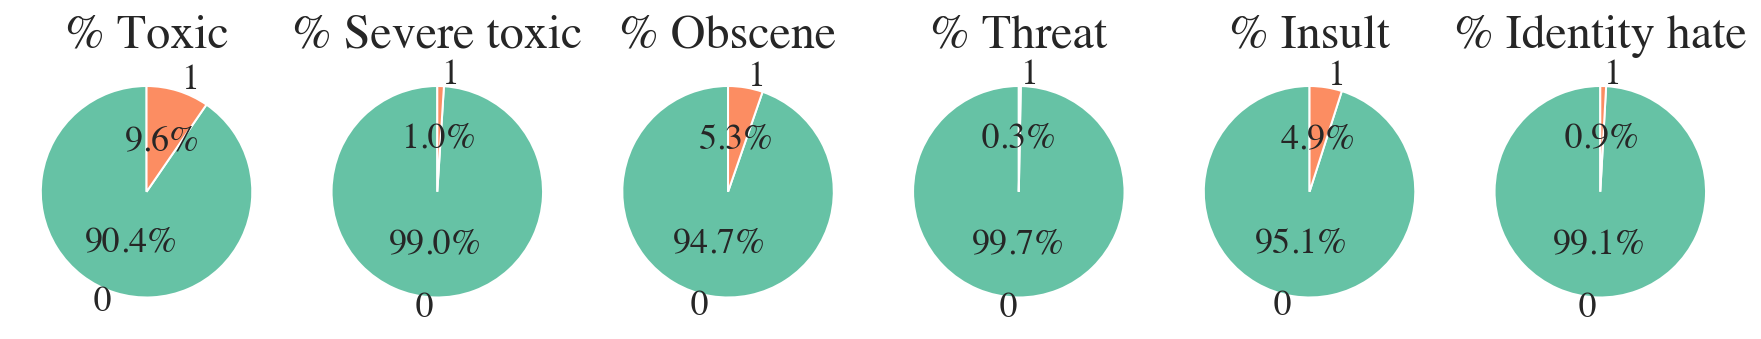

In [229]:
sns.set_palette("Set2")

labels_setup = ['Toxic','Severe toxic','Obscene','Threat','Insult','Identity hate']
matplotlib.rcParams['font.size'] = 24

plt.figure(figsize=(18, 7))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.2)
for i in range(1, 7):
    plt.subplot(1, 7, i)
    plt.pie(train[labels[i-1]].value_counts(), labels=train[labels[i-1]].unique(), shadow=False, autopct='%1.1f%%', startangle=90, pctdistance=0.5, textprops={'fontsize': 18})
    title = '% ' + str(labels_setup[i-1])
    plt.title(title, fontweight="bold", size=24)
plt.savefig('../plots/label_distribution_par_label.png', bbox_inches='tight')

**Observations**
- imbalanced data

In [230]:
count_labels = train[labels].apply(lambda x: x.sum(), axis=1).value_counts()[1:]

In [231]:
pct_labels = count_labels/np.sum(count_labels)

In [232]:
pct_labels

1    0.391988
3    0.259414
2    0.214484
4    0.108475
5    0.023729
6    0.001911
dtype: float64

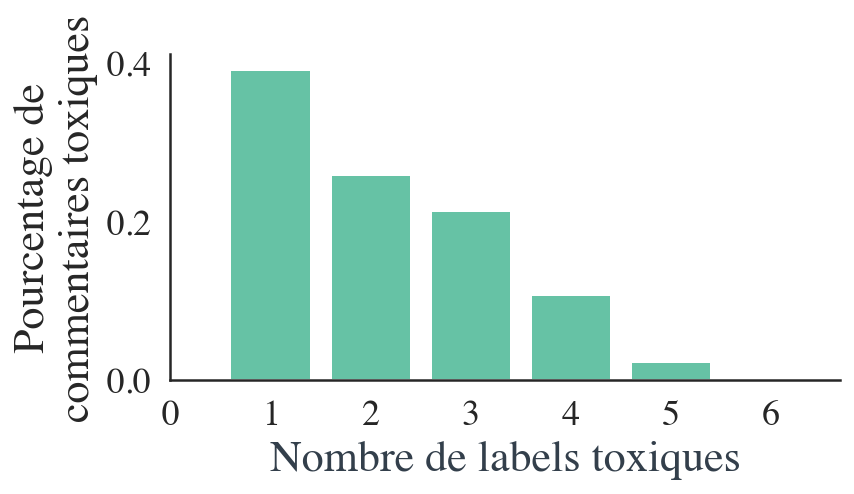

In [233]:
sns.set_style("white")
matplotlib.rcParams['font.family'] = "times"

my_range=list(range(1,len(pct_labels.index)+1))

fig, ax = plt.subplots(figsize=(6,3))

plt.bar(my_range, pct_labels)
ax.set_xlabel('Nombre de labels toxiques', fontsize=22, fontweight='bold', color = '#333F4B')
ax.set_ylabel('Pourcentage de\ncommentaires toxiques', fontsize=22, fontweight='bold')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.set_xticks(np.arange(len(pct_labels)+1))

def stylize_axes(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

stylize_axes(ax)

plt.savefig('../plots/nb_comments_label_toxiques.png', bbox_inches='tight')

##### Recherche de corrélation

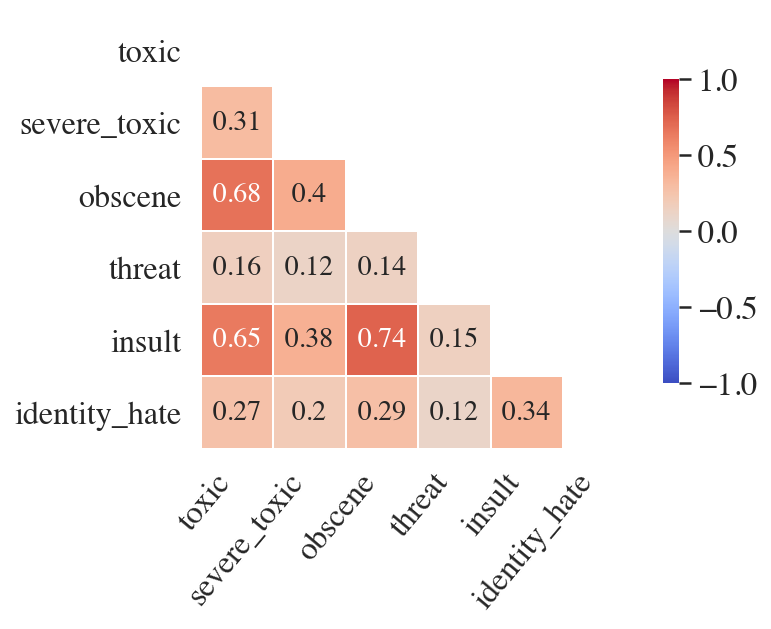

In [234]:
sns.set_style("white")
matplotlib.rcParams['font.family'] = "times"
#sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(5, 4))
mask = np.triu(np.ones_like(train[labels].corr(), dtype=np.bool))
g=sns.heatmap(train[labels].corr(), annot=True, vmin=-1, vmax=1, center=0, mask=mask, square=True, linewidths=.5, annot_kws={"size": 14}, cbar_kws={"shrink": .7}, cmap='coolwarm')
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 16)
g.set_xticklabels(g.get_xticklabels(), rotation = 50, fontsize = 16, horizontalalignment="right")
plt.savefig('../plots/correlation_matrix.png', bbox_inches='tight')

**Commentaires**

- corrélation apparente entre toxic, obscene et insult

<a id='12'></a>
#### 1.2.  Analyse des commentaires

##### Analyse de la longueur des comentaires (nombre de mots)

In [235]:
from scipy import stats
print(stats.shapiro(train[train.total == 0]['comment_text'].apply(lambda x: len(x.split()))))
print(stats.shapiro(train[train.total >= 1]['comment_text'].apply(lambda x: len(x.split()))))

(0.5866892337799072, 0.0)
(0.40473473072052, 0.0)


In [240]:
sans_toxicite = train[train.total == 0]['comment_text'].apply(lambda x: len(x.split()))
avec_toxicite = train[train.total >= 1]['comment_text'].apply(lambda x: len(x.split()))

print(stats.mannwhitneyu(sans_toxicite, avec_toxicite, alternative='two-sided'))

str1 = ["Sans toxicité"] * len(sans_toxicite)
str2 = ["Avec toxicité"] * len(avec_toxicite)
cat_var = str1 + str2
value = pd.concat([sans_toxicite, avec_toxicite])
df = pd.DataFrame({"categorical_var" : cat_var, "value" : value})

MannwhitneyuResult(statistic=1418033760.0, pvalue=0.0)


0.15790515728293728


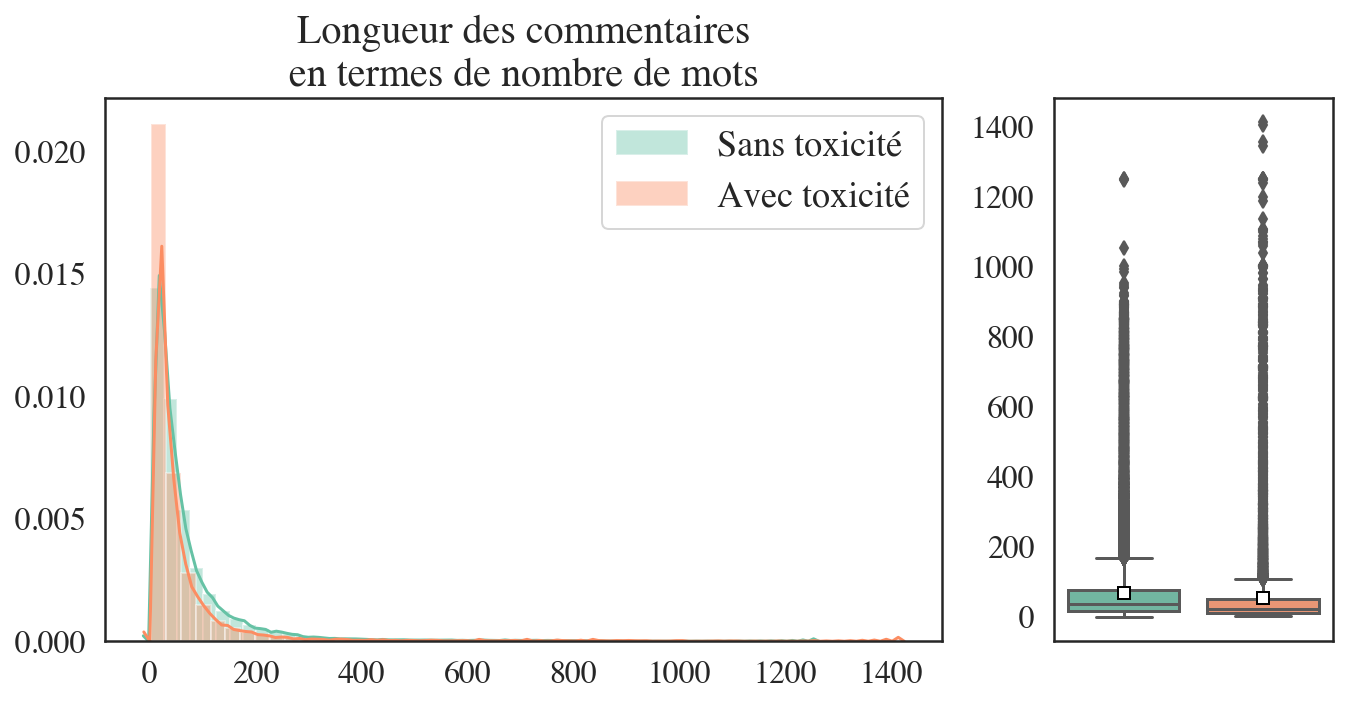

In [242]:
sns.set_palette("Set2")
matplotlib.rcParams['font.family'] = "times"

plt.figure(figsize=(11, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])

plt.subplot(gs[0])
sns.distplot(sans_toxicite, label='Sans toxicité')
sns.distplot(avec_toxicite, label='Avec toxicité')
plt.legend(fontsize=18)
plt.xlabel(None)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Longueur des commentaires\nen termes de nombre de mots", fontsize=20)

plt.subplot(gs[1])
g = sns.boxplot(x=df["categorical_var"], y=df["value"], showmeans=True, meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"})
#add_stat_annotation(g, data=df, x="categorical_var", y="value",
#                    box_pairs=[(("Sans toxicité"), ("Avec toxicité"))],
#                    test='t-test_ind', text_format='star', loc='outside', verbose=2)
plt.xlabel(None)
plt.ylabel(None)
plt.xticks([])
plt.yticks(fontsize=16)

plt.savefig('../plots/distributions_comment.png', bbox_inches='tight')

cohens_d = (np.mean(sans_toxicite) - np.mean(avec_toxicite)) / (np.sqrt((np.std(sans_toxicite) ** 2 + np.std(avec_toxicite) ** 2) / 2))
print(cohens_d)

##### Analyse de la longueur des comentaires (nombre de caractères)

In [244]:
from scipy import stats
print(stats.shapiro(train[train.total == 0]['comment_caract_len']))
print(stats.shapiro(train[train.total >= 1]['comment_caract_len']))

(0.5782915353775024, 0.0)
(0.40767115354537964, 0.0)


In [245]:
sans_toxicite = train[train.total == 0]['comment_caract_len']
avec_toxicite = train[train.total >= 1]['comment_caract_len']

print(stats.mannwhitneyu(sans_toxicite, avec_toxicite, alternative='two-sided'))

str1 = ["Sans toxicité"] * len(sans_toxicite)
str2 = ["Avec toxicité"] * len(avec_toxicite)
cat_var = str1 + str2
value = pd.concat([sans_toxicite, avec_toxicite])
df = pd.DataFrame({"categorical_var" : cat_var, "value" : value})

MannwhitneyuResult(statistic=1439115036.0, pvalue=0.0)


0.16752107315450168


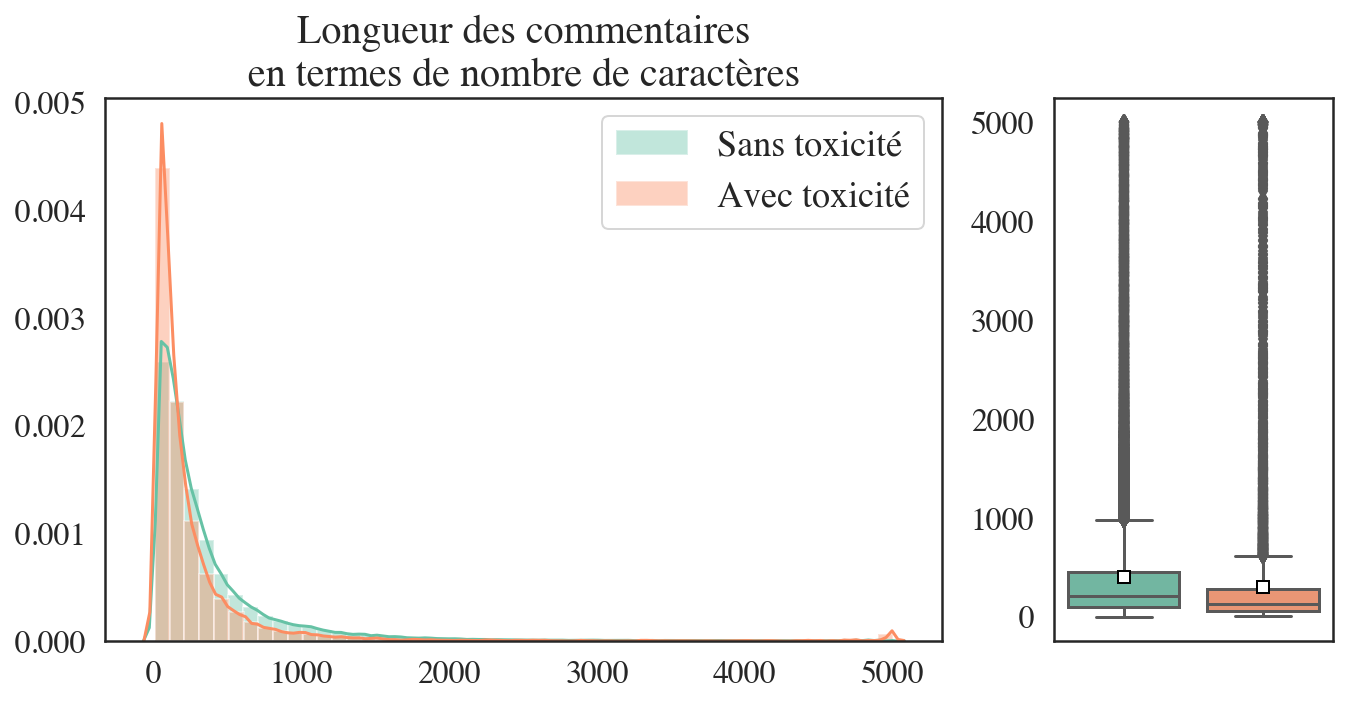

In [247]:
sns.set_palette("Set2")
matplotlib.rcParams['font.family'] = "times"

plt.figure(figsize=(11, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])

plt.subplot(gs[0])
sns.distplot(sans_toxicite, label='Sans toxicité')
sns.distplot(avec_toxicite, label='Avec toxicité')
plt.legend(fontsize=18)
plt.xlabel(None)
plt.title("Longueur des commentaires\nen termes de nombre de caractères", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(gs[1])
g = sns.boxplot(x=df["categorical_var"], y=df["value"], showmeans=True, meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"})
#add_stat_annotation(g, data=df, x="categorical_var", y="value",
#                    box_pairs=[(("Sans toxicité"), ("Avec toxicité"))],
#                    test='t-test_ind', text_format='star', loc='outside', verbose=2)
plt.xlabel(None)
plt.ylabel(None)
plt.xticks([])
plt.yticks(fontsize=16)

plt.savefig('../plots/distributions_comment_nb_caracteres.png', bbox_inches='tight')

cohens_d = (np.mean(sans_toxicite) - np.mean(avec_toxicite)) / (np.sqrt((np.std(sans_toxicite) ** 2 + np.std(avec_toxicite) ** 2) / 2))
print(cohens_d)

In [87]:
train.comment_caract_len.describe()

count    159571.000000
mean     394.073221   
std      590.720282   
min      6.000000     
25%      96.000000    
50%      205.000000   
75%      435.000000   
max      5000.000000  
Name: comment_caract_len, dtype: float64

##### Analyse de l'usage des majuscules dans les commentaires

In [248]:
from scipy import stats
print(stats.shapiro(train[train.total == 0]['uppercases']))
print(stats.shapiro(train[train.total >= 1]['uppercases']))

(0.40430891513824463, 0.0)
(0.5164089202880859, 0.0)


In [249]:
sans_toxicite = np.log(train[train.total == 0]['uppercases']+1)
avec_toxicite = np.log(train[train.total >= 1]['uppercases']+1)

print(stats.mannwhitneyu(sans_toxicite, avec_toxicite, alternative='two-sided'))

str1 = ["Sans toxicité"] * len(sans_toxicite)
str2 = ["Avec toxicité"] * len(avec_toxicite)
cat_var = str1 + str2
value = pd.concat([sans_toxicite, avec_toxicite])
df = pd.DataFrame({"categorical_var" : cat_var, "value" : value})

MannwhitneyuResult(statistic=1072466567.0, pvalue=1.8719047584299464e-59)


-0.4279575153543007


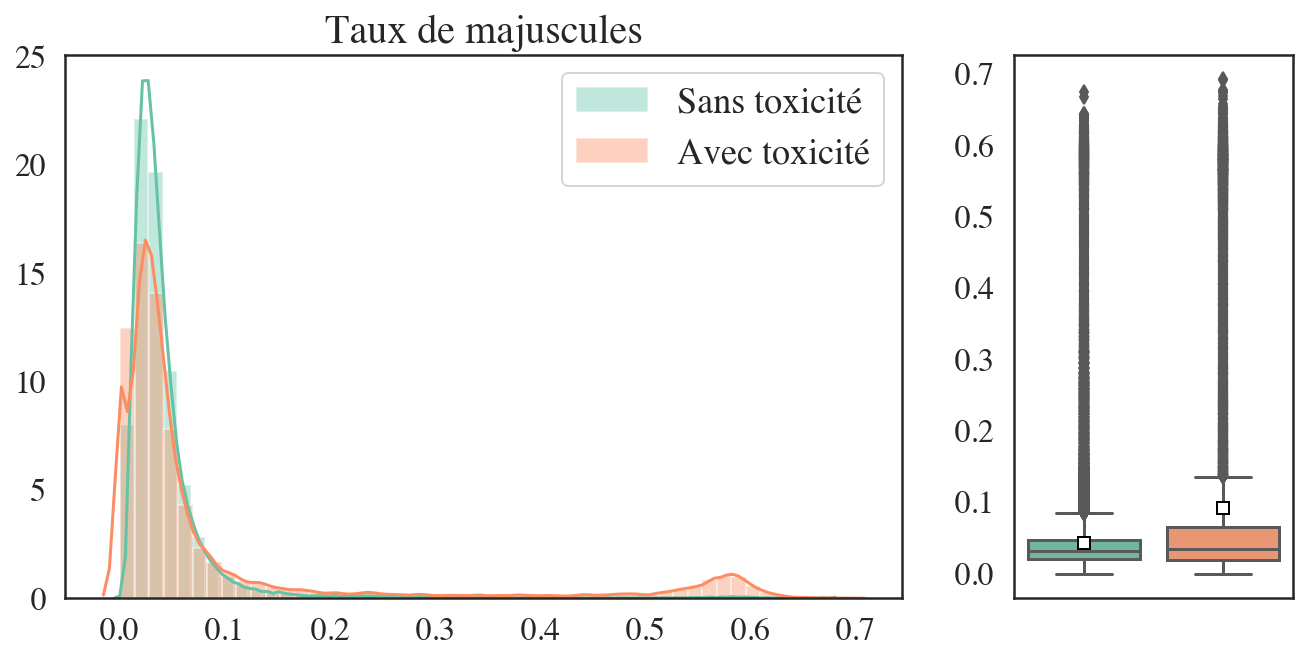

In [250]:
sns.set_palette("Set2")
matplotlib.rcParams['font.family'] = "times"

plt.figure(figsize=(11, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])

plt.subplot(gs[0])
sns.distplot(sans_toxicite, label='Sans toxicité')
sns.distplot(avec_toxicite, label='Avec toxicité')
plt.legend(fontsize=18)
plt.xlabel(None)
plt.title("Taux de majuscules", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(gs[1])
g = sns.boxplot(x=df["categorical_var"], y=df["value"], showmeans=True, meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"})
#add_stat_annotation(g, data=df, x="categorical_var", y="value",
#                    box_pairs=[(("Sans toxicité"), ("Avec toxicité"))],
#                    test='t-test_ind', text_format='star', loc='outside', verbose=2)
plt.xlabel(None)
plt.ylabel(None)
plt.xticks([])
plt.yticks(fontsize=16)

plt.savefig('../plots/distributions_comment_majuscules.png', bbox_inches='tight')

cohens_d = (np.mean(sans_toxicite) - np.mean(avec_toxicite)) / (np.sqrt((np.std(sans_toxicite) ** 2 + np.std(avec_toxicite) ** 2) / 2))
print(cohens_d)

In [117]:
train[(train.type == 'neutre')].uppercases.describe()

count    143346.000000
mean     0.044897     
std      0.065372     
min      0.000000     
25%      0.020833     
50%      0.031579     
75%      0.047619     
max      0.962963     
Name: uppercases, dtype: float64

In [118]:
train[(train.type == 'toxique')].uppercases.describe()

count    16225.000000
mean     0.111038    
std      0.207561    
min      0.000000    
25%      0.019380    
50%      0.034682    
75%      0.068071    
max      0.998189    
Name: uppercases, dtype: float64

**Commentaire**

Dans les commentaires avec un moins un label toxique, l'usage des majuscules semblent plus important. Il ne faudra pas retirer ces majuscules lors du cleaning des données.

##### Analyse de l'usage de la ponctuation dans les commentaires

In [251]:
from scipy import stats
print(stats.shapiro(train[train.total == 0]['punctation']))
print(stats.shapiro(train[train.total >= 1]['punctation']))

(0.7427254915237427, 0.0)
(0.6228762269020081, 0.0)


In [252]:
sans_toxicite = train[train.total == 0]['punctation']
avec_toxicite = train[train.total >= 1]['punctation']

print(stats.mannwhitneyu(sans_toxicite, avec_toxicite, alternative='two-sided'))

str1 = ["Sans toxicité"] * len(sans_toxicite)
str2 = ["Avec toxicité"] * len(avec_toxicite)
cat_var = str1 + str2
value = pd.concat([sans_toxicite, avec_toxicite])
df = pd.DataFrame({"categorical_var" : cat_var, "value" : value})

MannwhitneyuResult(statistic=1184347319.5, pvalue=0.00011450127242591898)


-0.045340112465500425


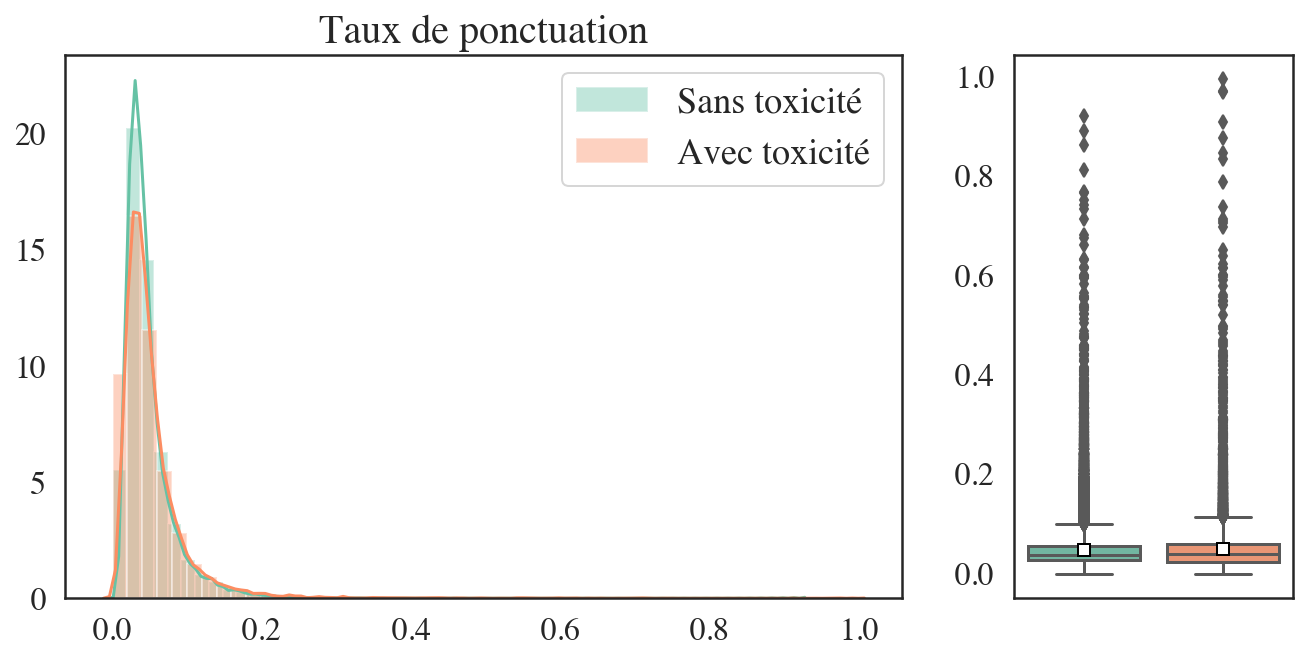

In [253]:
sns.set_palette("Set2")
matplotlib.rcParams['font.family'] = "times"

plt.figure(figsize=(11, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])

plt.subplot(gs[0])
sns.distplot(sans_toxicite, label='Sans toxicité')
sns.distplot(avec_toxicite, label='Avec toxicité')
plt.legend(fontsize=18)
plt.xlabel(None)
plt.title("Taux de ponctuation", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(gs[1])
g = sns.boxplot(x=df["categorical_var"], y=df["value"], showmeans=True, meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"})
#add_stat_annotation(g, data=df, x="categorical_var", y="value",
#                    box_pairs=[(("Sans toxicité"), ("Avec toxicité"))],
#                    test='t-test_ind', text_format='star', loc='outside', verbose=2)
plt.xlabel(None)
plt.ylabel(None)
plt.xticks([])
plt.yticks(fontsize=16)

plt.savefig('../plots/distributions_comment_ponctuation.png', bbox_inches='tight')

cohens_d = (np.mean(sans_toxicite) - np.mean(avec_toxicite)) / (np.sqrt((np.std(sans_toxicite) ** 2 + np.std(avec_toxicite) ** 2) / 2))
print(cohens_d)

In [85]:
train[train.total == 0].punctation.describe()

count    143346.000000
mean     0.046921     
std      0.035788     
min      0.000000     
25%      0.026490     
50%      0.038095     
75%      0.055935     
max      0.920382     
Name: punctation, dtype: float64

In [86]:
train[train.total > 0].punctation.describe()

count    16225.000000
mean     0.048943    
std      0.051939    
min      0.000000    
25%      0.023810    
50%      0.038462    
75%      0.059701    
max      0.994366    
Name: punctation, dtype: float64

In [254]:
train['exclamation_count'] = train.comment_text.str.count('!')

In [255]:
from scipy import stats
print(stats.shapiro(train[train.total == 0]['exclamation_count']))
print(stats.shapiro(train[train.total >= 1]['exclamation_count']))

(0.006895303726196289, 0.0)
(0.01800447702407837, 0.0)


In [256]:
sans_toxicite = np.log(train[train.total == 0]['exclamation_count']+1)
avec_toxicite = np.log(train[train.total >= 1]['exclamation_count']+1)

print(stats.mannwhitneyu(sans_toxicite, avec_toxicite, alternative='two-sided'))

str1 = ["Sans toxicité"] * len(sans_toxicite)
str2 = ["Avec toxicité"] * len(avec_toxicite)
cat_var = str1 + str2
value = pd.concat([sans_toxicite, avec_toxicite])
df = pd.DataFrame({"categorical_var" : cat_var, "value" : value})

MannwhitneyuResult(statistic=997898254.5, pvalue=0.0)


-0.3802612592660866


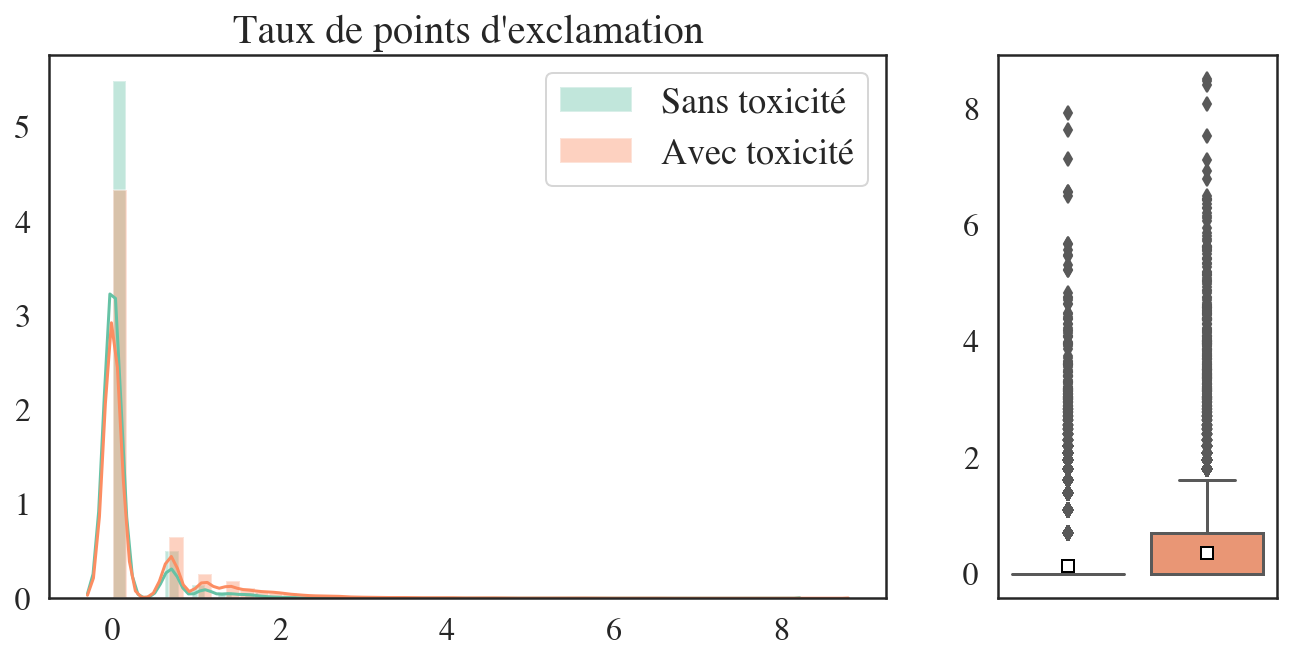

In [257]:
sns.set_palette("Set2")
matplotlib.rcParams['font.family'] = "times"

plt.figure(figsize=(11, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])

plt.subplot(gs[0])
sns.distplot(sans_toxicite, label='Sans toxicité', kde_kws={'bw':0.1})
sns.distplot(avec_toxicite, label='Avec toxicité', kde_kws={'bw':0.1})
plt.legend(fontsize=18)
plt.xlabel(None)
plt.title("Taux de points d'exclamation", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(gs[1])
g = sns.boxplot(x=df["categorical_var"], y=df["value"], showmeans=True, meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"})
#add_stat_annotation(g, data=df, x="categorical_var", y="value",
#                    box_pairs=[(("Sans toxicité"), ("Avec toxicité"))],
#                    test='t-test_ind', text_format='star', loc='outside', verbose=2)
plt.xlabel(None)
plt.ylabel(None)
plt.xticks([])
plt.yticks(fontsize=16)

plt.savefig('../plots/distributions_comment_exclamation.png', bbox_inches='tight')

cohens_d = (np.mean(sans_toxicite) - np.mean(avec_toxicite)) / (np.sqrt((np.std(sans_toxicite) ** 2 + np.std(avec_toxicite) ** 2) / 2))
print(cohens_d)

In [39]:
train[train.total == 0].exclamation_count.describe()

count    143346.000000
mean     0.343442     
std      10.450405    
min      0.000000     
25%      0.000000     
50%      0.000000     
75%      0.000000     
max      2762.000000  
Name: exclamation_count, dtype: float64

In [116]:
train[train.total > 0].exclamation_count.describe()

count    16225.000000
mean     3.472727    
std      74.991734   
min      0.000000    
25%      0.000000    
50%      0.000000    
75%      1.000000    
max      4942.000000 
Name: exclamation_count, dtype: float64

##### Analyse des mots les plus utilisés dans les commentaires

In [ ]:
plt.figure(figsize=(18,12))
plt.subplot(121)
plt.title('Mots les plus utilisés dans les commentaires méchants', fontweight="bold", fontsize=12)
sns.countplot(y=train[train.total >= 1]['comment_text'].str.split(expand=True).unstack(),
             order=train[train.total >= 1]['comment_text'].str.split(expand=True).unstack().value_counts()[:50].index)
plt.subplot(122)
plt.title('Mots les plus utilisés dans les commentaires gentils', fontweight="bold", fontsize=12)
sns.countplot(y=train[train.total == 0]['comment_text'].str.split(expand=True).unstack(),
             order=train[train.total == 0]['comment_text'].str.split(expand=True).unstack().value_counts()[:50].index)
plt.show()

**Observations**

1eres différences entre les commentaires gentils et méchants : 
- utilisation de mots en majuscules
- de mots vulgaires

On pourra affiner cette analyse après avoir fait un cleaning des mots

##### Analyse des mots les plus utilisés dans les commentaires nettoyés

In [210]:
# Déclaration des stopwords
stop_words = set(stopwords.words('english'))

# Déclaration du tokenizer
tokenizer = nltk.RegexpTokenizer(r"\w+")#pattern = r'[^a-zA-Z0-9\s]'

# Déclaration du lemmatizer
nltk.download('wordnet')
lemmatizer = nltk.stem.WordNetLemmatizer()

from string import digits
remove_digits = str.maketrans('', '', digits)

def cleaning(comment):
    # Step 1: Transform the string into lower case words
    comment_no_digit = comment.translate(remove_digits)
    comment_lower = comment_no_digit.lower().replace('\d+', '')
    
    tokens = tokenizer.tokenize(comment_lower)
    tokens_without_sw = [word for word in tokens if not word in stop_words]
            
    return tokens_without_sw

def strg(x):
    return (" ".join(x))

train['comment_preprocessed'] = train.comment_text.apply(lambda x: cleaning(x))
train['comment_cleaned'] = train.comment_preprocessed.apply(lambda x: strg(x))

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/camillecochener/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


KeyboardInterrupt: 

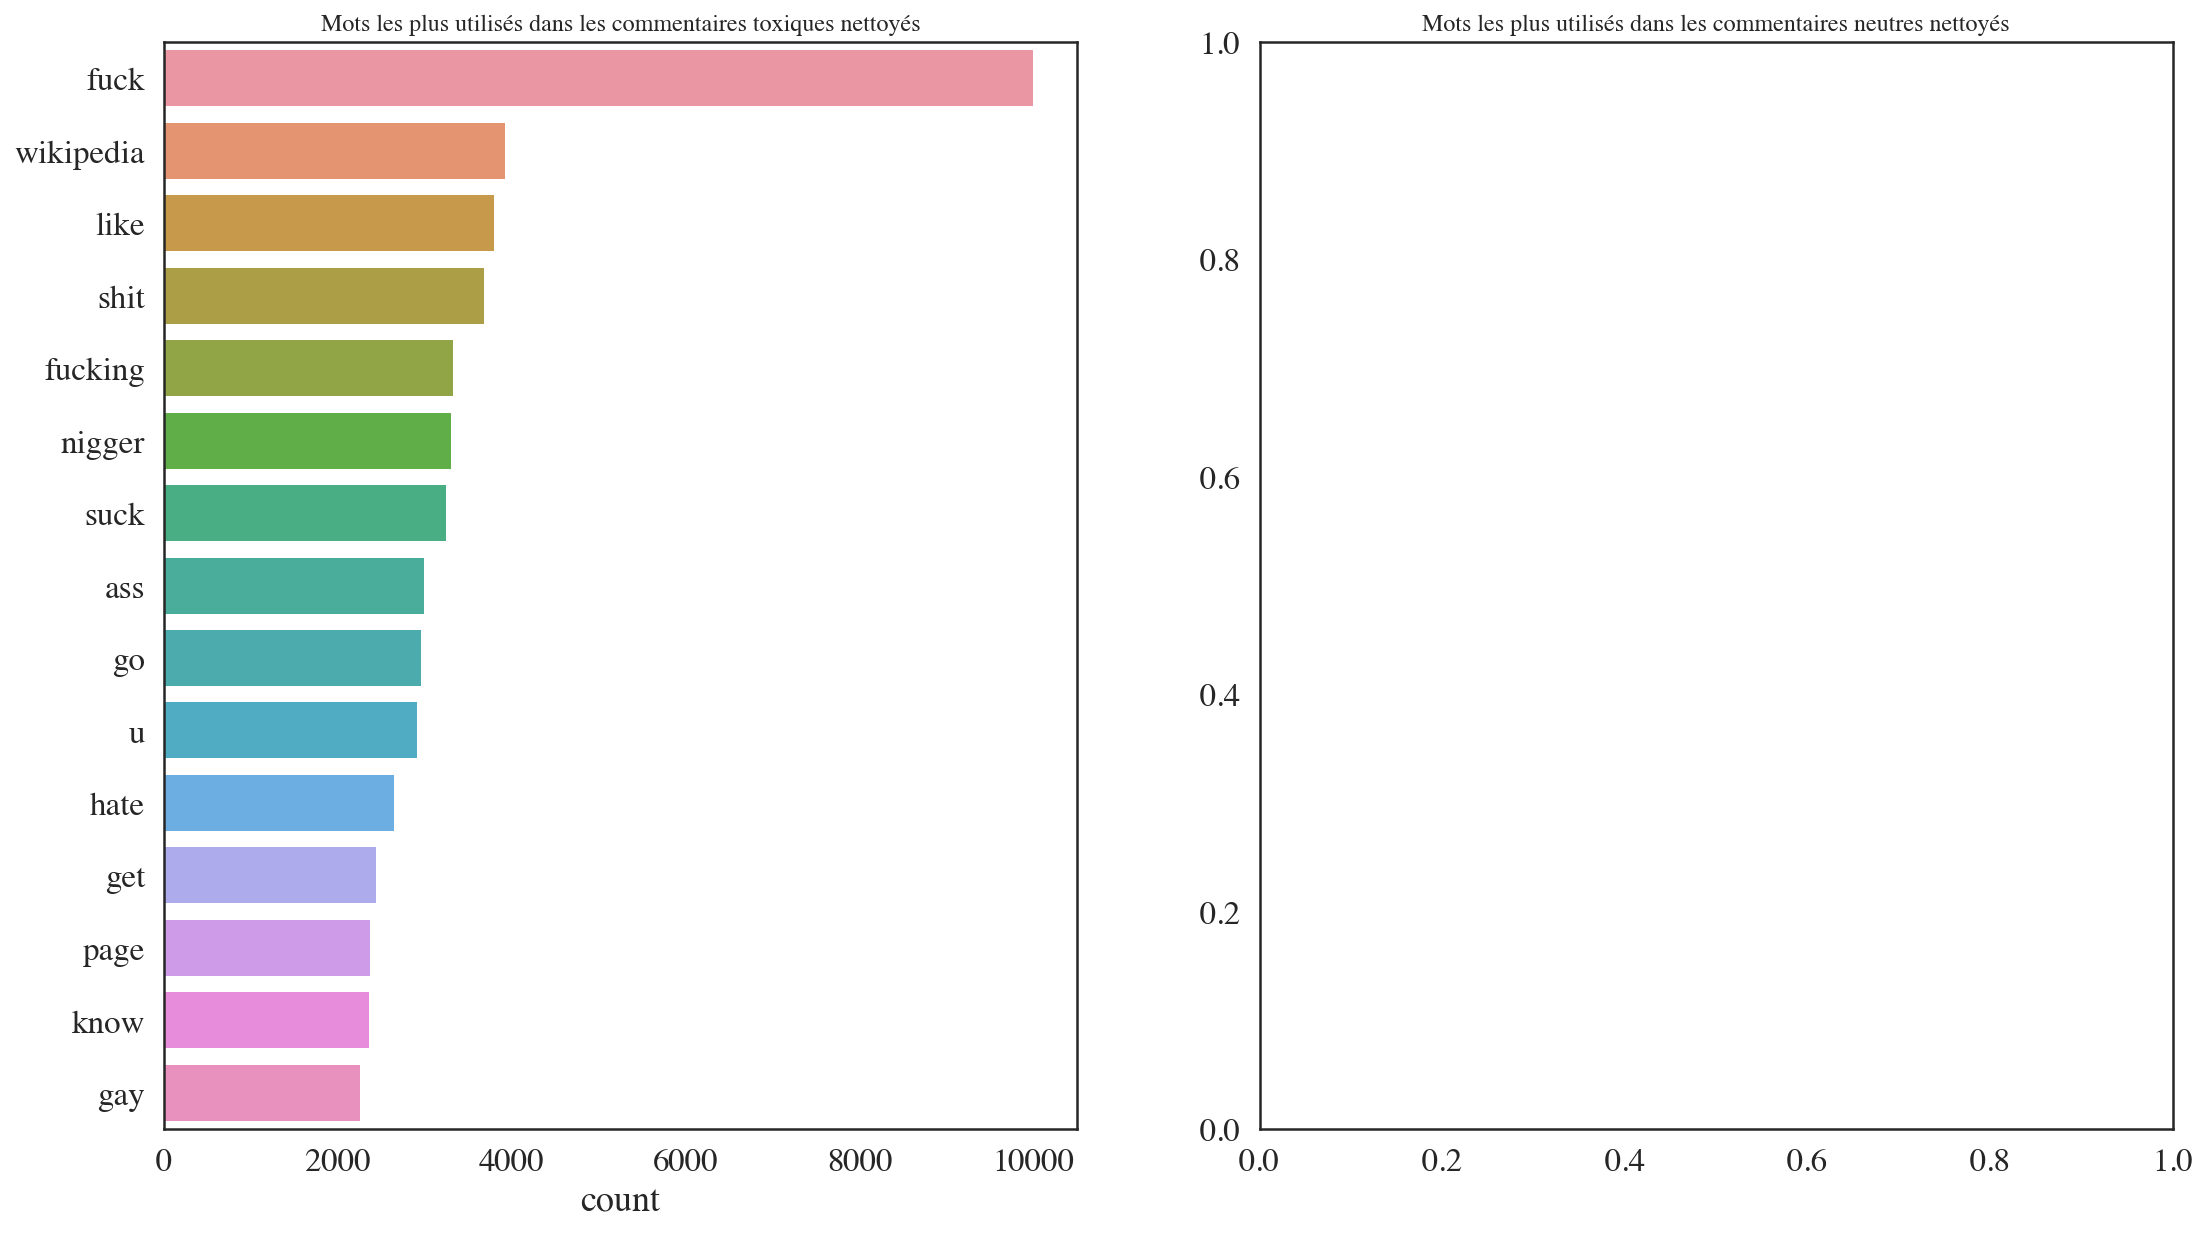

In [212]:
sns.set_palette("Set2")
matplotlib.rcParams['font.family'] = "times"
plt.figure(figsize=(18,10))
plt.subplot(121)
plt.title('Mots les plus utilisés dans les commentaires toxiques nettoyés', fontweight="bold", fontsize=12)
sns.countplot(y=train[train.total >= 1]['comment_cleaned'].str.split(expand=True).unstack(),
             order=train[train.total >= 1]['comment_cleaned'].str.split(expand=True).unstack().value_counts()[:15].index)
plt.subplot(122)
plt.title('Mots les plus utilisés dans les commentaires neutres nettoyés', fontweight="bold", fontsize=12)
sns.countplot(y=train[train.total == 0]['comment_cleaned'].str.split(expand=True).unstack(),
             order=train[train.total == 0]['comment_cleaned'].str.split(expand=True).unstack().value_counts()[:15].index)
plt.show()
plt.savefig('../plots/mots_les_plus_utilisés_comment_clean.png', bbox_inches='tight');